<a href="https://colab.research.google.com/github/kavyau7/Machine-Learning/blob/master/vgg16_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
'''
•	VGG16 and LSTM
•	ResNet and LSTM
•	Inceptionv3 and GRU
•	ResNet and GRU
•	VGG16 and GRU
'''

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [3]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
os.chdir('/content/drive/MyDrive/')
print(os.getcwd())

/content/drive/MyDrive


In [13]:
!unzip Flickr8k_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Flickr8k_Dataset/286660725_ffdbdf3481.jpg  
  inflating: Flickr8k_Dataset/2866686547_0a67eb899d.jpg  
  inflating: Flickr8k_Dataset/2866696346_4dcccbd3a5.jpg  
  inflating: Flickr8k_Dataset/2866820467_ae699235a7.jpg  
  inflating: Flickr8k_Dataset/2866974237_e3c1e267c0.jpg  
  inflating: Flickr8k_Dataset/2867026654_38be983b44.jpg  
  inflating: Flickr8k_Dataset/2867699650_e6ddb540de.jpg  
  inflating: Flickr8k_Dataset/2867736861_43c9487a65.jpg  
  inflating: Flickr8k_Dataset/2867845624_22e4fe0a23.jpg  
  inflating: Flickr8k_Dataset/2867937005_91c092b157.jpg  
  inflating: Flickr8k_Dataset/2867968184_908d87cf2c.jpg  
  inflating: Flickr8k_Dataset/2868136205_3cf679208d.jpg  
  inflating: Flickr8k_Dataset/2868324804_5cc8030484.jpg  
  inflating: Flickr8k_Dataset/2868575889_2c030aa8ae.jpg  
  inflating: Flickr8k_Dataset/2868668723_0741222b23.jpg  
  inflating: Flickr8k_Dataset/2868776402_aef437e493.jpg  
  inflating: Flickr8k_

In [14]:
!unzip Flickr8k_text.zip

Archive:  Flickr8k_text.zip
  inflating: Flickr8k_text/CrowdFlowerAnnotations.txt  
  inflating: Flickr8k_text/ExpertAnnotations.txt  
  inflating: Flickr8k_text/Flickr_8k.devImages.txt  
  inflating: Flickr8k_text/Flickr_8k.testImages.txt  
  inflating: Flickr8k_text/Flickr_8k.trainImages.txt  
  inflating: Flickr8k_text/Flickr8k.lemma.token.txt  
  inflating: Flickr8k_text/Flickr8k.token.txt  
  inflating: Flickr8k_text/readme.txt  


In [36]:
!unzip glove.6B.200d.txt.zip

Archive:  glove.6B.200d.txt.zip
  inflating: glove.6B.200d.txt       


In [16]:
import shutil

shutil.move('/content/drive/MyDrive/Flickr8k_Dataset','/content/Flickr8k/Flickr8k_Dataset')
shutil.move('/content/drive/MyDrive/Flickr8k_text','/content/Flickr8k/')
shutil.move('/content/drive/MyDrive/glove.6B.200d.txt','/content/')

'/content/glove6b'

In [17]:
#read contents of captions variable
images_path = '/content/Flickr8k/Flickr8k_Dataset/'
captions='/content/Flickr8k/Flickr8k_text/Flickr8k.token.txt'

train_images_path = '/content/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = '/content/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'

glove_path = '/content/'

doc = open(captions,'r').read()
print(doc[:200])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A lit


 # **Image Processing**

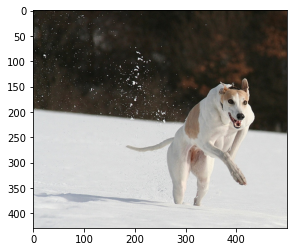

In [ ]:
pic = '101654506_8eb26cfb60.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

In [18]:
def encode_vgg(trn_img):
    # VGG16 model
    VGG16_model = VGG16()
    VGG16_model = Model(inputs=VGG16_model.inputs, outputs=VGG16_model.layers[-2].output)
    
    print(VGG16_model.summary())
    
    features = dict()

    for name in trn_img:
        image = load_img(name, target_size=(224, 224))

        # convert the image pixels to a numpy array
        image = img_to_array(image)

        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        # prepare the image for the VGG model
        image = preprocess_input(image)

        # get features
        feature = VGG16_model.predict(image, verbose=0)
        feature=feature.reshape(4096,)
        
        # get image id
        image_id = name[len(images_path):].split('.')[0]
        
        # store feature
        features[image_id] = feature
        
    return features

In [19]:
#  we save all the training and testing images in train_img and test_img lists respectively
img = glob.glob(images_path + '*.jpg')
print(img[:100])
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)
    
print(train_img[:10])    

['/content/Flickr8k/Flickr8k_Dataset/2292406847_f366350600.jpg', '/content/Flickr8k/Flickr8k_Dataset/2612488996_9450de0e54.jpg', '/content/Flickr8k/Flickr8k_Dataset/369186134_5eef374112.jpg', '/content/Flickr8k/Flickr8k_Dataset/1626754053_81126b67b6.jpg', '/content/Flickr8k/Flickr8k_Dataset/3487261028_30791528ec.jpg', '/content/Flickr8k/Flickr8k_Dataset/2261962622_e9318a95eb.jpg', '/content/Flickr8k/Flickr8k_Dataset/2554570943_122da6438f.jpg', '/content/Flickr8k/Flickr8k_Dataset/3184112120_6ddcd98016.jpg', '/content/Flickr8k/Flickr8k_Dataset/2661437618_ca7a15f3cb.jpg', '/content/Flickr8k/Flickr8k_Dataset/300594071_3450444752.jpg', '/content/Flickr8k/Flickr8k_Dataset/2205328215_3ffc094cde.jpg', '/content/Flickr8k/Flickr8k_Dataset/2289096282_4ef120f189.jpg', '/content/Flickr8k/Flickr8k_Dataset/3540155303_08225a4567.jpg', '/content/Flickr8k/Flickr8k_Dataset/3670907052_c827593564.jpg', '/content/Flickr8k/Flickr8k_Dataset/3569284680_44fef444ef.jpg', '/content/Flickr8k/Flickr8k_Dataset/46831

In [20]:
train_features_vgg = {} # dict with key: image_name and val: feature vector of that particular image
train_features_vgg = encode_vgg(train_img)

test_features_vgg = {}
test_features_vgg = encode_vgg(test_img)

i=0
for k,v in train_features_vgg.items():
    if i>4:
        break
    i+=1
    print('key:',k,'\tvalue:',v)

553476096/553467096 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [21]:
type(train_features_vgg[list(train_features_vgg.keys())[0]])
print(train_features_vgg[list(train_features_vgg.keys())[0]])
print(train_features_vgg[list(train_features_vgg.keys())[0]].shape)

[1.6100428 0.7566842 0.3710349 ... 0.        1.5985272 1.2958809]
(4096,)


In [22]:
import pickle
with open('train_features_vgg.pickle', 'wb') as f:
    pickle.dump(train_features_vgg, f)
    
with open('test_features_vgg.pickle', 'wb') as f:
    pickle.dump(train_features_vgg, f)

In [ ]:
# load the pickled file
import pickle
with open('train_features_vgg.pickle', 'rb') as f:
    train_features_vgg = pickle.load(f)
    
with open('test_features_vgg.pickle', 'rb') as f:
    test_features_vgg = pickle.load(f)

# **Text Processing**

In [23]:
# group together all the description of a particular image
# image name will be the key and all the 5 captions related 
# to the image will value.
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split("\t")
        if len(line) > 2:
            image_id = tokens[0].split('.')[0]
            image_desc = ' '.join(tokens[1:])
            if image_id not in descriptions:
                descriptions[image_id] = list()
            descriptions[image_id].append(image_desc)

print('key:\t101654506_8eb26cfb60\nvalue:\n',descriptions['101654506_8eb26cfb60'])

key:	101654506_8eb26cfb60
value:
 ['A brown and white dog is running through the snow .', 'A dog is running in the snow', 'A dog running through snow .', 'a white and brown dog is running through a snow covered field .', 'The white and brown dog is running over the surface of the snow .']


**clean the text**

In [24]:
# get rid of all the punctuation and 
# convert the descriptions to lowercase
train_descriptions = dict()  # training data.. with image name and list of captions
doc = open(train_images_path,'r').read()

table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc if len(word)>1 and word.isalpha()]
        desc = [w.translate(table) for w in desc]
        intermediate = ' '.join(desc)
        desc_list[i] =  'startseq '+ intermediate + ' endseq'
    if key+".jpg" in doc:
        train_descriptions[key]=desc_list
print('key:\t101654506_8eb26cfb60\nvalue:\n',descriptions['101654506_8eb26cfb60'])

key:	101654506_8eb26cfb60
value:
 ['startseq brown and white dog is running through the snow endseq', 'startseq dog is running in the snow endseq', 'startseq dog running through snow endseq', 'startseq white and brown dog is running through snow covered field endseq', 'startseq the white and brown dog is running over the surface of the snow endseq']


In [25]:
'''
# concatenate image and description .. just like it appeared in
# captions.txt
lines = list()
i=0
for key, desc_list in descriptions.items():
    for desc in desc_list:
        desc = desc.replace('startseq ','')
        desc = desc.replace(' endseq','')
        lines.append(key + ' ' + desc)
        i+=1
new_descriptions = '\n'.join(lines)
print(new_descriptions[:350])
'''

"\n# concatenate image and description .. just like it appeared in\n# captions.txt\nlines = list()\ni=0\nfor key, desc_list in descriptions.items():\n    for desc in desc_list:\n        desc = desc.replace('startseq ','')\n        desc = desc.replace(' endseq','')\n        lines.append(key + ' ' + desc)\n        i+=1\nnew_descriptions = '\n'.join(lines)\nprint(new_descriptions[:350])\n"

In [ ]:
'''
train_descriptions = dict()  # training data.. with image name and list of captions
doc = open(train_images_path,'r').read()
dataset = list()    # contains list of training images
for line in doc.split('\n'):
    if len(line) > 1:
        identifier = line.split('.')[0]
        dataset.append(identifier)
        train_descriptions[identifier]=descriptions[identifier]
    
train_images = set(dataset)
i=0
for key,val in train_descriptions.items():
    if i>4:
        break
    print(key,val)
    i+=1
'''

In [ ]:
'''print(list(train_images)[5])'''

**create vocabulary**

In [26]:
# have all the training captions in a list
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        #cap=cap.replace('startseq','')
        #cap=cap.replace('endseq','')
        all_train_captions.append(cap)
all_train_captions[:6]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq']

In [27]:
# create a vocabulary of all the unique words present across 
# all the image captions in the data set
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))
print("List of first 10 vocabulary:")
print(list(vocabulary)[0:10])

Original Vocabulary Size: 8367
List of first 10 vocabulary:
['birds', 'shoe', 'woman', 'dust', 'boxes', 'aerobatic', 'bun', 'shorts', 'leashed', 'roman']


In [28]:
vocab=vocabulary

In [ ]:
# reduce vocabulary to only those words which occur atleast 
# 10 times in the entire corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

In [29]:
# create two dictionaries to map words to an index and vice versa

ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [30]:
#print wordtoix values to check index of every word
i=1
keys1=list(wordtoix.keys())
while i<6:
    print("wordtoix:\n\t\t key:",keys1[i],"\tvalue: ",wordtoix.get(keys1[i]))
    i+=1
print('vocab_size : ',vocab_size)

wordtoix:
		 key: shoe 	value:  2
wordtoix:
		 key: woman 	value:  3
wordtoix:
		 key: dust 	value:  4
wordtoix:
		 key: boxes 	value:  5
wordtoix:
		 key: aerobatic 	value:  6
vocab_size :  8368


In [31]:
# max length of a training caption
max_length=0
for l in all_train_captions:
    max_length=max(max_length,len(l.split()))
print(max_length)

33


In [39]:
glove_path = '/content/'
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [40]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# resnet model
# image_model = ResNet50(include_top=True, weights='imagenet')
# model = ResNet50()

In [ ]:
#os. listdir('../input/') # to display list of contents
#Image.open(img_name_vector[0]) # to open an image

In [41]:
from keras.layers import GRU

# feature extractor model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
#se1 = Embedding(vocab_size, 256, embeddings_initializer='glorot_uniform', mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = GRU(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# summarize model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 200)      1673600     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [42]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [43]:
# a function that can train the data in batches

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence to make it same length as that of the max_length_caption in training data
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    # 1 is placed where words occur otherwise 0
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [44]:
len(test_features_vgg.keys())

1027

In [45]:
epochs = 30 #4
batch_size = 3 #0.7
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features_vgg, wordtoix, max_length, batch_size)
#X.shape, y_in.shape, y_out.shape
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(174, 4096)
(174, 33)
(174, 8368)


In [46]:
hist=model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
2018/2018 [==============================] - 203s 94ms/step - loss: 5.0651
Epoch 2/30
2018/2018 [==============================] - 191s 94ms/step - loss: 3.8871
Epoch 3/30
2018/2018 [==============================] - 191s 95ms/step - loss: 3.5702
Epoch 4/30
2018/2018 [==============================] - 189s 94ms/step - loss: 3.3848
Epoch 5/30
2018/2018 [==============================] - 188s 93ms/step - loss: 3.2571
Epoch 6/30
2018/2018 [==============================] - 189s 93ms/step - loss: 3.1641
Epoch 7/30
2018/2018 [==============================] - 188s 93ms/step - loss: 3.0916
Epoch 8/30
2018/2018 [==============================] - 188s 93ms/step - loss: 3.0387
Epoch 9/30
2018/2018 [==============================] - 189s 94ms/step - loss: 2.9916
Epoch 10/30
2018/2018 [==============================] - 189s 94ms/step - loss: 2.9530
Epoch 11/30
2018/2018 [==============================] - 188s 93ms/step - loss: 2.9222
Epoch 12/30
2018/2018 [=============================

In [ ]:
help(Model.fit)

In [47]:
hist.history

{'loss': [4.596012592315674,
  3.796675443649292,
  3.522318124771118,
  3.3529226779937744,
  3.2375872135162354,
  3.1488142013549805,
  3.080441951751709,
  3.027036666870117,
  2.9833931922912598,
  2.950179100036621,
  2.9225096702575684,
  2.891871213912964,
  2.8779678344726562,
  2.8603243827819824,
  2.857490301132202,
  2.8324928283691406,
  2.822985887527466,
  2.811039686203003,
  2.8028078079223633,
  2.7974324226379395,
  2.7863399982452393,
  2.7774229049682617,
  2.7787418365478516,
  2.771596908569336,
  2.769482135772705,
  2.7655301094055176,
  2.7605628967285156,
  2.7574350833892822,
  2.7553515434265137,
  2.7581639289855957]}

In [ ]:
np.mean(hist.history['acc'])

In [48]:
# loading model as a pickle file
import pickle
with open('hist.pickle', 'wb') as f:
    pickle.dump(hist, f)

TypeError: ignored

In [49]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [50]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [53]:
test_list=list(test_features_vgg.keys())

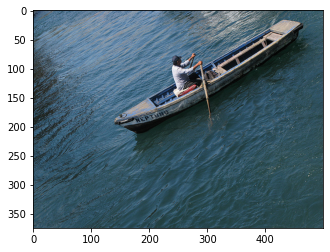

Greedy Search: man is sitting on dock with his arms out out out of water
Beam Search, K = 3: man is sitting on the pier in the water with his arms out to the water
Beam Search, K = 5: man is sitting on the pier in the water
Beam Search, K = 7: man is sitting on the pier in the water at the edge of water
Beam Search, K = 10: group of people are sitting on dock under the water


In [52]:
pic = test_list[0]
image = test_features_vgg[pic].reshape((1,4096))
x=plt.imread(images_path+pic+'.jpg')
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

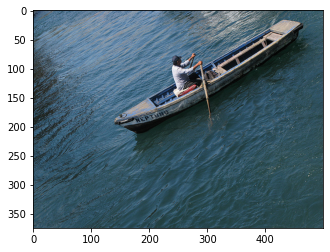

training description: ['startseq man in rowboat is rowing across blue water endseq', 'startseq man is rowing in small boat called neptuno endseq', 'startseq man rows his boat below endseq', 'startseq man rowing boat endseq', 'startseq the fisherman paddles in his to new spot endseq']

Greedy: the light and the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Bleu score: 0.420448
Cumulative 1-gram: 0.031250
Cumulative 2-gram: 0.176777
Cumulative 3-gram: 0.318640
Cumulative 4-gram: 0.420448

Beam Search, K = 3: the light and the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Bleu score: 0.420448
Cumulative 1-gram: 0.031250
Cumulative 2-gram: 0.176777
Cumulative 3-gram: 0.318640
Cumulative 4-gram: 0.420448

Beam Search, K = 5: the light and the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Bleu score: 0.420448
Cumulative 1-gram: 0.031250
Cumulative 2-gram: 0.176777
Cumulative 3-gram: 0.318640
Cumulative 4-gram: 0.420448

Beam Search, K = 7: an indoor plant on the
Bleu score: 0.668740
Cumulative 1-gram: 0.200000
Cumulative 2-gram: 0.447214
Cumulative 3-gram: 0.587949
Cumulative 4-gram: 0.668740
----------------------------------------


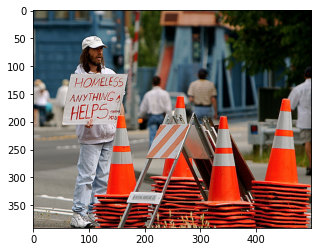

training description: ['startseq homeless man in white cap is standing behind large orange cones endseq', 'startseq homeless man standing in construction site endseq', 'startseq homeless man stands with sign next to orange construction cones endseq', 'startseq man holds sign reading homeless anything helps near construction site endseq', 'startseq stacks of orange safety cones in front of man holding up homeless sign endseq']

Greedy: the two people are walking down the street
Bleu score: 0.000000
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000

Beam Search, K = 3: the man is near the
Bleu score: 0.483016
Cumulative 1-gram: 0.329287
Cumulative 2-gram: 0.425108
Cumulative 3-gram: 0.463675
Cumulative 4-gram: 0.483016

Beam Search, K = 5: the man is near the
Bleu score: 0.483016
Cumulative 1-gram: 0.329287
Cumulative 2-gram: 0.425108
Cumulative 3-gram: 0.463675
Cumulative 4-gram: 0.483016

Beam Search, K = 7: group of people 

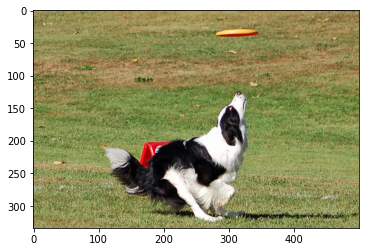

training description: ['startseq black and white dog is going after an orange frisbee endseq', 'startseq black and white dog leaps to catch an orange frisbee endseq', 'startseq black and white dog prepares to catch frisbee endseq', 'startseq dog about to jump to catch frisbee endseq', 'startseq dog jumping for frisbee endseq']

Greedy: black and white dog is running through the grass
Bleu score: 0.446324
Cumulative 1-gram: 0.555556
Cumulative 2-gram: 0.527046
Cumulative 3-gram: 0.495436
Cumulative 4-gram: 0.446324

Beam Search, K = 3: black and white dog is running through the grass
Bleu score: 0.446324
Cumulative 1-gram: 0.555556
Cumulative 2-gram: 0.527046
Cumulative 3-gram: 0.495436
Cumulative 4-gram: 0.446324

Beam Search, K = 5: black and white dog is running through the grass
Bleu score: 0.446324
Cumulative 1-gram: 0.555556
Cumulative 2-gram: 0.527046
Cumulative 3-gram: 0.495436
Cumulative 4-gram: 0.446324

Beam Search, K = 7: black and white dog runs through the grass
Bleu score

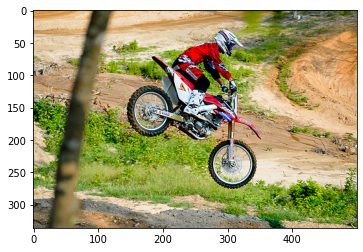

training description: ['startseq bmx rider in red and black outfit is jumping on his motorcycle endseq', 'startseq dirt biker flies through the air endseq', 'startseq guy in red on bike in midair endseq', 'startseq man in red outfit jumps his motocross bike down the hill endseq', 'startseq someone in red on bike is moving in midair endseq']

Greedy: dirt bike rider is riding bike on the hill


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Bleu score: 0.558395
Cumulative 1-gram: 0.777778
Cumulative 2-gram: 0.311805
Cumulative 3-gram: 0.463407
Cumulative 4-gram: 0.558395

Beam Search, K = 3: the man is riding bike down the hill
Bleu score: 0.382603
Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.566947
Cumulative 3-gram: 0.478507
Cumulative 4-gram: 0.382603

Beam Search, K = 5: the man is riding bike down the hill
Bleu score: 0.382603
Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.566947
Cumulative 3-gram: 0.478507
Cumulative 4-gram: 0.382603

Beam Search, K = 7: the man is riding bike down the hill
Bleu score: 0.382603
Cumulative 1-gram: 0.750000
Cumulative 2-gram: 0.566947
Cumulative 3-gram: 0.478507
Cumulative 4-gram: 0.382603
----------------------------------------


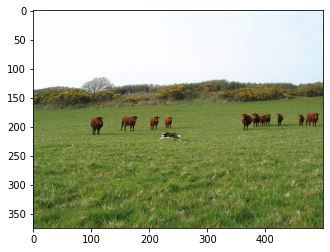

training description: ['startseq black and white dog is running through cow field endseq', 'startseq black and white dog running in the grass where there are some cows endseq', 'startseq calf is running in the fields while cows look on endseq', 'startseq cow herd grazing in the pasture with dog running in the foreground endseq', 'startseq dog running in the grass around sheep endseq']

Greedy: brown dog is running through the grass
Bleu score: 0.367415
Cumulative 1-gram: 0.644123
Cumulative 2-gram: 0.568063
Cumulative 3-gram: 0.461735
Cumulative 4-gram: 0.367415

Beam Search, K = 3: brown and white dog is running through the grass
Bleu score: 0.660633
Cumulative 1-gram: 0.888889
Cumulative 2-gram: 0.816497
Cumulative 3-gram: 0.727256
Cumulative 4-gram: 0.660633

Beam Search, K = 5: brown and white dog is running through the grass
Bleu score: 0.660633
Cumulative 1-gram: 0.888889
Cumulative 2-gram: 0.816497
Cumulative 3-gram: 0.727256
Cumulative 4-gram: 0.660633

Beam Search, K = 7: brow

IndexError: ignored

In [36]:
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu

def calculateBleu(reference,candidate):
    print('Bleu score: %f' % sentence_bleu(reference, candidate))
    print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
    print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
    print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
    print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))
    

def printMethod(pic):
    image = test_features_vgg[pic].reshape((1,4096))
    x=plt.imread(images_path+pic+'.jpg')
    plt.imshow(x)
    plt.show()

    training=[]
    train=[]
    
    for t in descriptions[pic.split('.')[0]]:
        train.append(t)
        training.append(t.split(" "))
    print("training description:",train)
    print("\nGreedy:",greedySearch(image))
    candidate=greedySearch(image).split(" ")
    calculateBleu(training,candidate)
    
    b1=beam_search_predictions(image, beam_index = 3)
    print("\nBeam Search, K = 3:",b1)
    calculateBleu(training,b1.split(" "))
    
    b2=beam_search_predictions(image, beam_index = 5)
    print("\nBeam Search, K = 5:",b2)
    calculateBleu(training,b2.split(" "))
    
    b2=beam_search_predictions(image, beam_index = 7)
    print("\nBeam Search, K = 7:",b2)
    calculateBleu(training,b2.split(" "))
    
    print("-"*40)
    
i=0
while i<20:
    printMethod(test_list[i])
    i+=1

In [56]:
g={'bleu':[],'bleu1':[],'bleu2':[],'bleu3':[],'bleu4':[]}
k3={'bleu':[],'bleu1':[],'bleu2':[],'bleu3':[],'bleu4':[]}
k5={'bleu':[],'bleu1':[],'bleu2':[],'bleu3':[],'bleu4':[]}
k7={'bleu':[],'bleu1':[],'bleu2':[],'bleu3':[],'bleu4':[]}
test_result={}

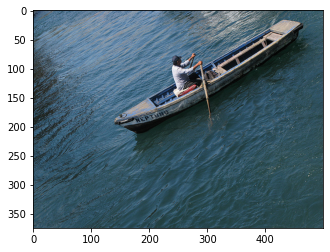

training description: ['startseq man in rowboat is rowing across blue water endseq', 'startseq man is rowing in small boat called neptuno endseq', 'startseq man rows his boat below endseq', 'startseq man rowing boat endseq', 'startseq the fisherman paddles in his to new spot endseq']

Greedy: man is sitting on dock with his arms out out out of water


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Cumulative 1-gram: 0.400160
Cumulative 1-gram: 0.307692
Cumulative 2-gram: 0.160128
Cumulative 3-gram: 0.298503
Cumulative 4-gram: 0.450217

Beam Search, K = 3: man is sitting on the pier in the water with his arms out to the water
Cumulative 1-gram: 0.413258
Cumulative 1-gram: 0.437500
Cumulative 2-gram: 0.170783
Cumulative 3-gram: 0.311467
Cumulative 4-gram: 0.448873

Beam Search, K = 5: man is sitting on the pier in the water
Cumulative 1-gram: 0.459361
Cumulative 1-gram: 0.497133
Cumulative 2-gram: 0.235811
Cumulative 3-gram: 0.371095
Cumulative 4-gram: 0.487171

Beam Search, K = 7: man is sitting on the pier in the water at the edge of water
Cumulative 1-gram: 0.407122
Cumulative 1-gram: 0.357143
Cumulative 2-gram: 0.165748
Cumulative 3-gram: 0.305377
Cumulative 4-gram: 0.451274


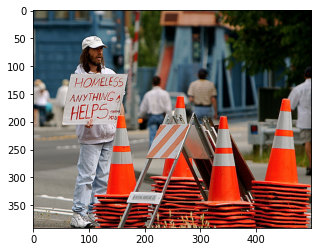

training description: ['startseq homeless man in white cap is standing behind large orange cones endseq', 'startseq homeless man standing in construction site endseq', 'startseq homeless man stands with sign next to orange construction cones endseq', 'startseq man holds sign reading homeless anything helps near construction site endseq', 'startseq stacks of orange safety cones in front of man holding up homeless sign endseq']

Greedy: man in black shirt is walking in the street
Cumulative 1-gram: 0.451801
Cumulative 1-gram: 0.333333
Cumulative 2-gram: 0.204124
Cumulative 3-gram: 0.350373
Cumulative 4-gram: 0.504266

Beam Search, K = 3: the man in the white shirt is walking down the street
Cumulative 1-gram: 0.398736
Cumulative 1-gram: 0.332037
Cumulative 2-gram: 0.174121
Cumulative 3-gram: 0.305871
Cumulative 4-gram: 0.441183

Beam Search, K = 5: the man in the white shirt is walking down the street
Cumulative 1-gram: 0.398736
Cumulative 1-gram: 0.332037
Cumulative 2-gram: 0.174121
Cum

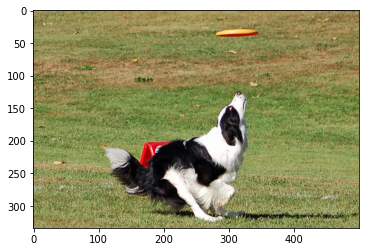

training description: ['startseq black and white dog is going after an orange frisbee endseq', 'startseq black and white dog leaps to catch an orange frisbee endseq', 'startseq black and white dog prepares to catch frisbee endseq', 'startseq dog about to jump to catch frisbee endseq', 'startseq dog jumping for frisbee endseq']

Greedy: dog is running through field
Cumulative 1-gram: 0.460406
Cumulative 1-gram: 0.327492
Cumulative 2-gram: 0.258905
Cumulative 3-gram: 0.382949
Cumulative 4-gram: 0.504586

Beam Search, K = 3: black and white dog runs through the grass
Cumulative 1-gram: 0.305098
Cumulative 1-gram: 0.441248
Cumulative 2-gram: 0.408517
Cumulative 3-gram: 0.369395
Cumulative 4-gram: 0.326995

Beam Search, K = 5: black and white dog runs through the grass
Cumulative 1-gram: 0.305098
Cumulative 1-gram: 0.441248
Cumulative 2-gram: 0.408517
Cumulative 3-gram: 0.369395
Cumulative 4-gram: 0.326995

Beam Search, K = 7: black and white dog runs through the grass
Cumulative 1-gram: 0.

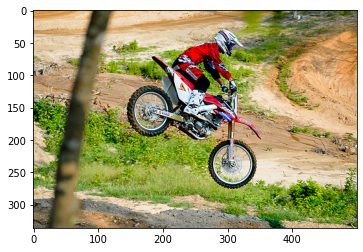

training description: ['startseq bmx rider in red and black outfit is jumping on his motorcycle endseq', 'startseq dirt biker flies through the air endseq', 'startseq guy in red on bike in midair endseq', 'startseq man in red outfit jumps his motocross bike down the hill endseq', 'startseq someone in red on bike is moving in midair endseq']

Greedy: man riding bike through the woods
Cumulative 1-gram: 0.432982
Cumulative 1-gram: 0.477688
Cumulative 2-gram: 0.261640
Cumulative 3-gram: 0.368523
Cumulative 4-gram: 0.450899

Beam Search, K = 3: mountain biker rides through the woods
Cumulative 1-gram: 0.402935
Cumulative 1-gram: 0.358266
Cumulative 2-gram: 0.226587
Cumulative 3-gram: 0.335147
Cumulative 4-gram: 0.431855

Beam Search, K = 5: mountain biker rides through the woods
Cumulative 1-gram: 0.402935
Cumulative 1-gram: 0.358266
Cumulative 2-gram: 0.226587
Cumulative 3-gram: 0.335147
Cumulative 4-gram: 0.431855

Beam Search, K = 7: mountain biker rides through the woods
Cumulative 1-g

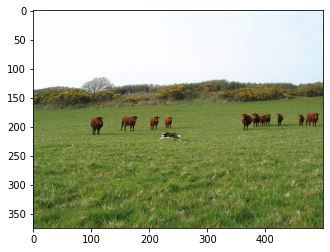

training description: ['startseq black and white dog is running through cow field endseq', 'startseq black and white dog running in the grass where there are some cows endseq', 'startseq calf is running in the fields while cows look on endseq', 'startseq cow herd grazing in the pasture with dog running in the foreground endseq', 'startseq dog running in the grass around sheep endseq']

Greedy: two girls are washing water from the grass
Cumulative 1-gram: 0.424567
Cumulative 1-gram: 0.330936
Cumulative 2-gram: 0.204258
Cumulative 3-gram: 0.335940
Cumulative 4-gram: 0.468321

Beam Search, K = 3: the mastif is walking through the brush
Cumulative 1-gram: 0.653366
Cumulative 1-gram: 0.429416
Cumulative 2-gram: 0.568063
Cumulative 3-gram: 0.624760
Cumulative 4-gram: 0.690972


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Beam Search, K = 5: the mastif is walking through the countryside
Cumulative 1-gram: 0.653366
Cumulative 1-gram: 0.429416
Cumulative 2-gram: 0.568063
Cumulative 3-gram: 0.624760
Cumulative 4-gram: 0.690972

Beam Search, K = 7: dog is running through the grass
Cumulative 1-gram: 0.366511
Cumulative 1-gram: 0.606531
Cumulative 2-gram: 0.542498
Cumulative 3-gram: 0.448263
Cumulative 4-gram: 0.366511


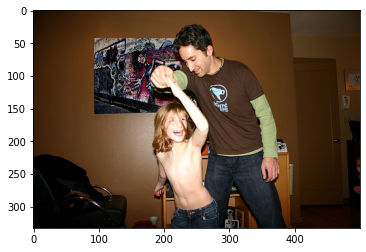

training description: ['startseq grown man and topless girl are dancing endseq', 'startseq shirtless child dances with an adult man endseq', 'startseq shirtless child plays with an adult indoors endseq', 'startseq man and child dancing endseq', 'startseq the man in the brown shirt is holding the hand of the long haired child in front of painting endseq']

Greedy: man in black shirt is sitting on the bench next to woman with red shirt
Cumulative 1-gram: 0.488923
Cumulative 1-gram: 0.400000
Cumulative 2-gram: 0.239046
Cumulative 3-gram: 0.388864
Cumulative 4-gram: 0.535839

Beam Search, K = 3: man in red shirt is sitting next to man wearing red hat
Cumulative 1-gram: 0.496168
Cumulative 1-gram: 0.333333
Cumulative 2-gram: 0.246183
Cumulative 3-gram: 0.396488
Cumulative 4-gram: 0.553785

Beam Search, K = 5: an older man and woman are looking at the top of the man in an orange shirt surrounded by photographers
Cumulative 1-gram: 0.256210
Cumulative 1-gram: 0.428053
Cumulative 2-gram: 0.292

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Beam Search, K = 7: the man in the blue shirt is sitting next to the man on the bed
Cumulative 1-gram: 0.210237
Cumulative 1-gram: 0.533333
Cumulative 2-gram: 0.390360
Cumulative 3-gram: 0.289805
Cumulative 4-gram: 0.223877


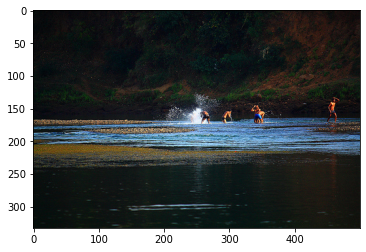

training description: ['startseq group of friends play in lake endseq', 'startseq five people are in natural water source endseq', 'startseq many children play in the water endseq', 'startseq people in bathing suits bend down and reach into the water of lake endseq', 'startseq several people are playing outside in the water endseq']

Greedy: man in black shirt is paddling canoe in the water
Cumulative 1-gram: 0.302138
Cumulative 1-gram: 0.300000
Cumulative 2-gram: 0.258199
Cumulative 3-gram: 0.206001
Cumulative 4-gram: 0.340794

Beam Search, K = 3: two people are standing on the water near the water
Cumulative 1-gram: 0.546024
Cumulative 1-gram: 0.400000
Cumulative 2-gram: 0.298142
Cumulative 3-gram: 0.449904
Cumulative 4-gram: 0.598420

Beam Search, K = 5: group of people are playing in the water near the water
Cumulative 1-gram: 0.533168
Cumulative 1-gram: 0.727273
Cumulative 2-gram: 0.603023
Cumulative 3-gram: 0.435973
Cumulative 4-gram: 0.550420

Beam Search, K = 7: group of people

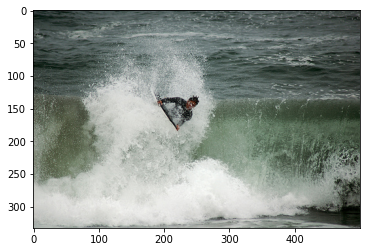

training description: ['startseq surfer catching big wave in the ocean endseq', 'startseq surfer going through wave endseq', 'startseq surfer in water and foam endseq', 'startseq surfer rides the crashing waves endseq', 'startseq the surfer catches big wave but stays on his board endseq']

Greedy: surfer rides wave
Cumulative 1-gram: 0.309349
Cumulative 1-gram: 0.367879
Cumulative 2-gram: 0.260130
Cumulative 3-gram: 0.292662
Cumulative 4-gram: 0.309349

Beam Search, K = 3: surfer rides wave
Cumulative 1-gram: 0.309349
Cumulative 1-gram: 0.367879
Cumulative 2-gram: 0.260130
Cumulative 3-gram: 0.292662
Cumulative 4-gram: 0.309349

Beam Search, K = 5: surfer is riding wave in the ocean
Cumulative 1-gram: 0.434721
Cumulative 1-gram: 0.714286
Cumulative 2-gram: 0.597614
Cumulative 3-gram: 0.526160
Cumulative 4-gram: 0.449597

Beam Search, K = 7: surfer is riding wave in the ocean
Cumulative 1-gram: 0.434721
Cumulative 1-gram: 0.714286
Cumulative 2-gram: 0.597614
Cumulative 3-gram: 0.526160


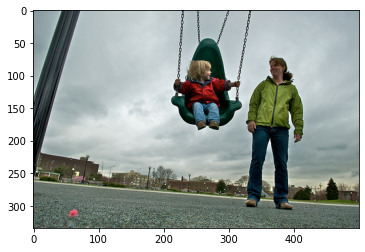

training description: ['startseq child on kiddie swing being pushed by woman endseq', 'startseq an adult smiles with child on swing endseq', 'startseq young woman watches as young blond boy swings in chair swing with buildings visible in the background endseq', 'startseq the woman stands outdoors next to child in swing endseq', 'startseq woman standing with child on swing endseq']

Greedy: young boy in red shirt is playing on the swing
Cumulative 1-gram: 0.880112
Cumulative 1-gram: 0.600000
Cumulative 2-gram: 0.774597
Cumulative 3-gram: 0.844870
Cumulative 4-gram: 0.926238

Beam Search, K = 3: young boy is playing on swing
Cumulative 1-gram: 0.432982
Cumulative 1-gram: 0.477688
Cumulative 2-gram: 0.261640
Cumulative 3-gram: 0.368523
Cumulative 4-gram: 0.450899

Beam Search, K = 5: young boy is playing on swing
Cumulative 1-gram: 0.432982
Cumulative 1-gram: 0.477688
Cumulative 2-gram: 0.261640
Cumulative 3-gram: 0.368523
Cumulative 4-gram: 0.450899

Beam Search, K = 7: young boy is play

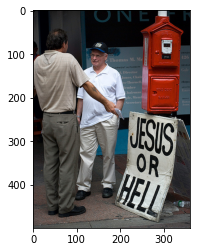

training description: ['startseq two men are standing beside sign that says jesus or hell endseq', 'startseq two men are standing in front of protest sign resting on red electric box endseq', 'startseq two men are talking on the street one is pointing at sign that says jesus or hell beneath red box and the other is standing there listening endseq', 'startseq two men discuss sign that says jesus or hell endseq', 'startseq two men talking by red box and poster endseq']

Greedy: man sleeps on the sidewalk with an umbrella
Cumulative 1-gram: 0.338561
Cumulative 1-gram: 0.194700
Cumulative 2-gram: 0.147180
Cumulative 3-gram: 0.259337
Cumulative 4-gram: 0.388904

Beam Search, K = 3: bearded man sleeps on the sidewalk next to bus
Cumulative 1-gram: 0.365317
Cumulative 1-gram: 0.198853
Cumulative 2-gram: 0.149140
Cumulative 3-gram: 0.274262
Cumulative 4-gram: 0.424610

Beam Search, K = 5: bearded man sleeps on the sidewalk next to bus
Cumulative 1-gram: 0.365317
Cumulative 1-gram: 0.198853
Cum

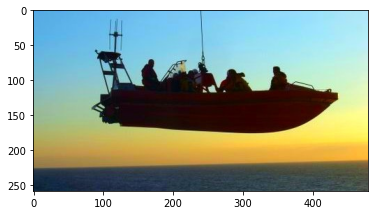

training description: ['startseq boat containing people is suspended by cable endseq', 'startseq boat suspended by cable over the water endseq', 'startseq raft hanging from rope over the ocean endseq', 'startseq small group of people are in small red boat and it is in the air over the ocean endseq', 'startseq the boat with passengers gets lifted out of the water by large cable endseq']

Greedy: man is sitting on dock with his arms out to the water
Cumulative 1-gram: 0.441163
Cumulative 1-gram: 0.416667
Cumulative 2-gram: 0.194625
Cumulative 3-gram: 0.339524
Cumulative 4-gram: 0.481526

Beam Search, K = 3: two people are sitting on dock near the ocean
Cumulative 1-gram: 0.577350
Cumulative 1-gram: 0.444444
Cumulative 2-gram: 0.333333
Cumulative 3-gram: 0.484284
Cumulative 4-gram: 0.626120

Beam Search, K = 5: two people are sitting on dock near the ocean
Cumulative 1-gram: 0.577350
Cumulative 1-gram: 0.444444
Cumulative 2-gram: 0.333333
Cumulative 3-gram: 0.484284
Cumulative 4-gram: 0.6

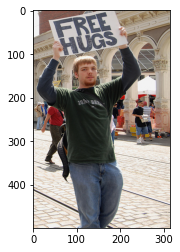

training description: ['startseq man carrying sign that says free hug along the sidewalk endseq', 'startseq man holds up free hugs sign above his head endseq', 'startseq man is holding sign that says free hugs endseq', 'startseq young man in black shirt is holding free hugs sign endseq', 'startseq the man is wearing green shirt and blue jeans and carrying free hugs sign endseq']

Greedy: man in black shirt is walking down the street
Cumulative 1-gram: 0.418013
Cumulative 1-gram: 0.596560
Cumulative 2-gram: 0.516636
Cumulative 3-gram: 0.470828
Cumulative 4-gram: 0.435311

Beam Search, K = 3: young boy in white shirt is walking down the street
Cumulative 1-gram: 0.485492
Cumulative 1-gram: 0.500000
Cumulative 2-gram: 0.235702
Cumulative 3-gram: 0.385265
Cumulative 4-gram: 0.520337

Beam Search, K = 5: young boy in blue shirt runs down the street
Cumulative 1-gram: 0.772551
Cumulative 1-gram: 0.497133
Cumulative 2-gram: 0.666974
Cumulative 3-gram: 0.737064
Cumulative 4-gram: 0.819321

Bea

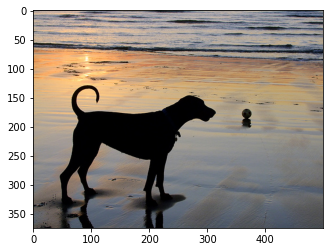

training description: ['startseq black dog is looking at the ball on the beach by the ocean endseq', 'startseq dog and ball on beach endseq', 'startseq dog standing on beach with ball nearby endseq', 'startseq dog stands on beach at sunset endseq', 'startseq dog in shadow on beach at sunset endseq']

Greedy: dog is running through the water
Cumulative 1-gram: 0.476012
Cumulative 1-gram: 0.423241
Cumulative 2-gram: 0.267681
Cumulative 3-gram: 0.395929
Cumulative 4-gram: 0.510177

Beam Search, K = 3: black dog is running through the snow
Cumulative 1-gram: 0.441792
Cumulative 1-gram: 0.571429
Cumulative 2-gram: 0.436436
Cumulative 3-gram: 0.340163
Cumulative 4-gram: 0.467220

Beam Search, K = 5: brown and white dog is running through the water
Cumulative 1-gram: 0.485492
Cumulative 1-gram: 0.444444
Cumulative 2-gram: 0.235702
Cumulative 3-gram: 0.385265
Cumulative 4-gram: 0.526502

Beam Search, K = 7: brown and white dog is running through the water
Cumulative 1-gram: 0.485492
Cumulative

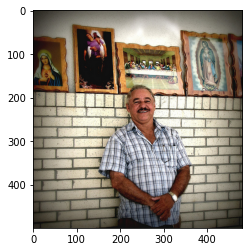

training description: ['startseq man is posing in front of brick wall that has framed pictures on it endseq', 'startseq man is standing in front of an interior brick wall with pictures along the top endseq', 'startseq middle aged man is standing next to white wall underneath some catholic theme pictures endseq', 'startseq smiling man in check shirt stands below row of religious pictures endseq', 'startseq pictures on white brick wall with smiling man standing in front of the wall endseq']

Greedy: man in black shirt is sitting on bench next to coffee cans
Cumulative 1-gram: 0.525046
Cumulative 1-gram: 0.536693
Cumulative 2-gram: 0.299630
Cumulative 3-gram: 0.438775
Cumulative 4-gram: 0.554122

Beam Search, K = 3: the man is standing next to the walls walls walls walls walls
Cumulative 1-gram: 0.305278
Cumulative 1-gram: 0.460022
Cumulative 2-gram: 0.392308
Cumulative 3-gram: 0.352321
Cumulative 4-gram: 0.327189

Beam Search, K = 5: the man is standing next to the walls walls walls wall

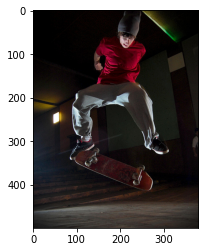

training description: ['startseq man in red shirt is doing trick with his skateboard endseq', 'startseq man wearing red shirt is skateboarding endseq', 'startseq skateboarder is performing trick in the air endseq', 'startseq skateboarder jumps in the air endseq', 'startseq person doing skateboard trick in midair endseq']

Greedy: man is doing trick on his bike
Cumulative 1-gram: 0.467138
Cumulative 1-gram: 0.714286
Cumulative 2-gram: 0.487950
Cumulative 3-gram: 0.366157
Cumulative 4-gram: 0.483123

Beam Search, K = 3: man is doing trick on his bike
Cumulative 1-gram: 0.467138
Cumulative 1-gram: 0.714286
Cumulative 2-gram: 0.487950
Cumulative 3-gram: 0.366157
Cumulative 4-gram: 0.483123

Beam Search, K = 5: man is doing trick on his bike
Cumulative 1-gram: 0.467138
Cumulative 1-gram: 0.714286
Cumulative 2-gram: 0.487950
Cumulative 3-gram: 0.366157
Cumulative 4-gram: 0.483123

Beam Search, K = 7: man sits on fire in front of an igloo engine
Cumulative 1-gram: 0.668740
Cumulative 1-gram: 

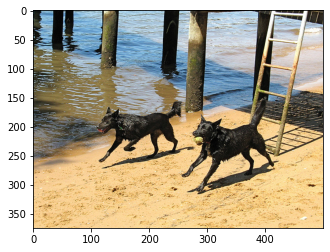

training description: ['startseq two black dogs each with running on the beach with balls in their mouths endseq', 'startseq two black dogs run in the sand by pier endseq', 'startseq two black dogs run through sand endseq', 'startseq two dogs run across the sand near boardwalk endseq', 'startseq two wet black dogs are running through some sand endseq']

Greedy: black dog is jumping up to catch ball in his mouth
Cumulative 1-gram: 0.652994
Cumulative 1-gram: 0.181818
Cumulative 2-gram: 0.426401
Cumulative 3-gram: 0.569745
Cumulative 4-gram: 0.774365

Beam Search, K = 3: black dog is jumping into the water
Cumulative 1-gram: 0.633783
Cumulative 1-gram: 0.247679
Cumulative 2-gram: 0.463366
Cumulative 3-gram: 0.573344
Cumulative 4-gram: 0.718369

Beam Search, K = 5: black dog jumps into the water
Cumulative 1-gram: 0.544446
Cumulative 1-gram: 0.238844
Cumulative 2-gram: 0.413690
Cumulative 3-gram: 0.498638
Cumulative 4-gram: 0.607669

Beam Search, K = 7: black dog jumps into the water
Cumu

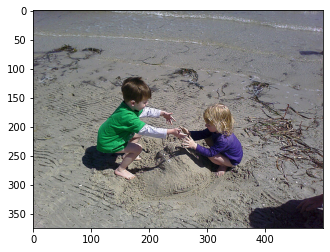

training description: ['startseq little girl and boy play in the sand on the beach endseq', 'startseq young boy and girl play together in the sand endseq', 'startseq boy and girl make sand castle endseq', 'startseq two children build sand castle on the beach endseq', 'startseq two kids building sand castle endseq']

Greedy: two girls are playing in the water
Cumulative 1-gram: 0.516973
Cumulative 1-gram: 0.428571
Cumulative 2-gram: 0.267261
Cumulative 3-gram: 0.418579
Cumulative 4-gram: 0.562685

Beam Search, K = 3: little boy in red shirt is running through the water
Cumulative 1-gram: 0.795271
Cumulative 1-gram: 0.400000
Cumulative 2-gram: 0.632456
Cumulative 3-gram: 0.739060
Cumulative 4-gram: 0.871583

Beam Search, K = 5: little boy in red shirt is running through the water
Cumulative 1-gram: 0.795271
Cumulative 1-gram: 0.400000
Cumulative 2-gram: 0.632456
Cumulative 3-gram: 0.739060
Cumulative 4-gram: 0.871583

Beam Search, K = 7: little boy in red shirt hangs upside down on the e

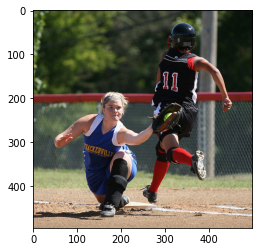

training description: ['startseq girl in blue and white uniform tags someone in black and red uniform endseq', 'startseq girl is catching baseball before an opponent touches base endseq', 'startseq woman in blue has yellow ball in her mitt endseq', 'startseq girl in blue tries to get base runner number out during softball game endseq', 'startseq two people playing ball on field endseq']

Greedy: baseball player in red and white guarding ready to hit the ball
Cumulative 1-gram: 0.479878
Cumulative 1-gram: 0.583333
Cumulative 2-gram: 0.230283
Cumulative 3-gram: 0.379396
Cumulative 4-gram: 0.506453

Beam Search, K = 3: baseball player in red and white guarding ready to hit the ball
Cumulative 1-gram: 0.479878
Cumulative 1-gram: 0.583333
Cumulative 2-gram: 0.230283
Cumulative 3-gram: 0.379396
Cumulative 4-gram: 0.506453

Beam Search, K = 5: baseball player playing game
Cumulative 1-gram: 0.342350
Cumulative 1-gram: 0.275910
Cumulative 2-gram: 0.318593
Cumulative 3-gram: 0.334561
Cumulative

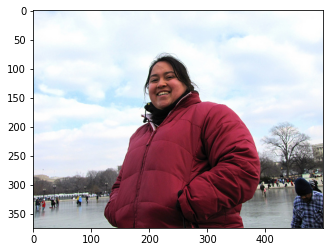

training description: ['startseq girl in red jacket surrounded by people endseq', 'startseq woman in puffy red jacket poses for picture at an ice skating rink endseq', 'startseq woman in red coat is smiling while people in the background are walking around in winter clothing endseq', 'startseq woman wearing red coat smiles down at the camera endseq', 'startseq the woman in red jacket is smiling at the camera endseq']

Greedy: man is standing on the edge of large rock
Cumulative 1-gram: 0.686589
Cumulative 1-gram: 0.222222
Cumulative 2-gram: 0.471405
Cumulative 3-gram: 0.608751
Cumulative 4-gram: 0.798028

Beam Search, K = 3: two people are standing on the edge of large rock
Cumulative 1-gram: 0.740083
Cumulative 1-gram: 0.300000
Cumulative 2-gram: 0.547723
Cumulative 3-gram: 0.672125
Cumulative 4-gram: 0.834773

Beam Search, K = 5: two people are standing on the edge of large rock
Cumulative 1-gram: 0.740083
Cumulative 1-gram: 0.300000
Cumulative 2-gram: 0.547723
Cumulative 3-gram: 0.6

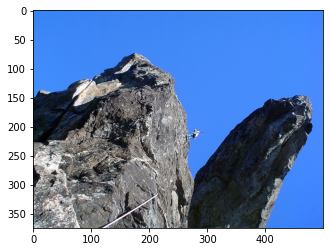

training description: ['startseq mountain climber looks down from the summit endseq', 'startseq person is rock climbing between two large rock faces endseq', 'startseq rock climber climbs in between two very large rocks endseq', 'startseq rock climber leans out from crag against deep blue sky endseq', 'startseq two large mountains stand high in the air as person tries to climb one endseq']

Greedy: man is climbing rock face
Cumulative 1-gram: 0.395460
Cumulative 1-gram: 0.269597
Cumulative 2-gram: 0.348049
Cumulative 3-gram: 0.379625
Cumulative 4-gram: 0.416186

Beam Search, K = 3: rock climber is climbing rock face
Cumulative 1-gram: 0.387539
Cumulative 1-gram: 0.505442
Cumulative 2-gram: 0.247615
Cumulative 3-gram: 0.335786
Cumulative 4-gram: 0.394669

Beam Search, K = 5: the man is climbing rock face
Cumulative 1-gram: 0.548062
Cumulative 1-gram: 0.404354
Cumulative 2-gram: 0.495230
Cumulative 3-gram: 0.530570
Cumulative 4-gram: 0.570741

Beam Search, K = 7: the man is climbing rock

In [57]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

def calculateBleu(ref, cand,d):
    b=sentence_bleu(ref, cand)
    d['bleu'].append(b)
    print('Cumulative 1-gram: %f' % b)
    b=sentence_bleu(ref, cand, weights = (1, 0, 0, 0))
    d['bleu1'].append(b)
    print('Cumulative 1-gram: %f' % b)
    b=sentence_bleu(ref, cand, weights = (0.5, 0.5, 0, 0))
    d['bleu2'].append(b)
    print('Cumulative 2-gram: %f' % b)
    b=sentence_bleu(ref, cand, weights = (0.33, 0.33, 0.33, 0))
    d['bleu3'].append(b)
    print('Cumulative 3-gram: %f' % b)
    b=sentence_bleu(ref, cand, weights = (0.15, 0.25, 0.25, 0.25))
    d['bleu4'].append(b)
    print('Cumulative 4-gram: %f' % b)
    
for i in range(20):
    pic = test_list[i]
    ima = test_features_vgg[pic].reshape((1,4096))
    x=plt.imread(images_path+pic+'.jpg')
    plt.imshow(x)
    plt.show()
    
    training = []
    train = []
    predicted=[]
    
    for t in descriptions[pic.split('.')[0]]:
        train.append(t)
        training.append(t.split(" "))
    print("training description:",train)
    print("\nGreedy:",greedySearch(ima))
    predicted.append(greedySearch(ima))
    candidate=greedySearch(ima).split(" ")
    calculateBleu(training,candidate,g)
    
    b1=beam_search_predictions(ima, beam_index = 3)
    print("\nBeam Search, K = 3:",b1)
    predicted.append(b1)
    calculateBleu(training,b1.split(" "),k3)
    
    b2=beam_search_predictions(ima, beam_index = 5)
    print("\nBeam Search, K = 5:",b2)
    predicted.append(b2)
    calculateBleu(training,b2.split(" "),k5)
    
    b3=beam_search_predictions(ima, beam_index = 7)
    print("\nBeam Search, K = 7:",b3)
    predicted.append(b3)
    calculateBleu(training,b3.split(" "),k7)
    
    test_result[pic]=[train,predicted]
    
print('done')

In [58]:
from statistics import mean

print('average for',len(g['bleu1']),'values:')

print('\nfor g:')
for key in g.keys():
    print(key,':',mean(g[key]))
    
print('\nfor k3:')
for key in k3.keys():
    print(key,':',mean(k3[key]))
    
print('\nfor k5:')
for key in k5.keys():
    print(key,':',mean(k5[key]))
    
print('\nfor k7:')
for key in k7.keys():
    print(key,':',mean(k7[key]))

average for 20 values:

for g:
bleu : 0.4774132295694943
bleu1 : 0.4006354682802208
bleu2 : 0.3139064013892017
bleu3 : 0.40476656113186354
bleu4 : 0.5200694758363232

for k3:
bleu : 0.4818418002135783
bleu1 : 0.42514278551445017
bleu2 : 0.3385239221672929
bleu3 : 0.41781911868248595
bleu4 : 0.5213388919788564

for k5:
bleu : 0.49099570504632223
bleu1 : 0.43918442867389174
bleu2 : 0.40206287195314233
bleu3 : 0.4439807675666839
bleu4 : 0.527528693368005

for k7:
bleu : 0.4815756051830206
bleu1 : 0.4147424197629984
bleu2 : 0.3798256137973772
bleu3 : 0.43988679049379853
bleu4 : 0.5234922119675853
